# Content

<ul>
    <li> Dataframes </li>
    <li> Training </li>
</ul>

## Indroduction

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '../../')
import prototype_nn as NN
from models import State
from models import Automata
import pandas as pd

This notebook, uses the testing data as input to the neural network. This will check if its is making the correct predictions.

## Dataframes

We want to see the data in the actual data simulation, and the predictions data that the neural network provides. The following code fragements below shows this

In [2]:
DELTA = 1
SIMULATIONS = 200
    
# This will produce test data from tempreture ranging 61-100, starting t(0) = initial = temp
initial_temp = [i for i in range(61, 90)]
for t_0 in initial_temp:
    COOLING = State("Cooling", lambda temp: True, lambda temp: -0.015*(temp - 22))
    newtons = Automata(COOLING, [COOLING], [lambda temp: True], t_0)
    newtons.run(t_0, DELTA, SIMULATIONS, "../../data/test/newtons_cooling_law.csv")

# This will produce carrying on from the simulations from the training set. 
# It will carry on from where each simulation for a inital temp stopped at (199).
# And carry on getting the rest of the simulation
initial_temp = [i for i in range(1, 10)]
for t_0 in initial_temp:
    COOLING = State("Cooling", lambda temp: True, lambda temp: -0.015*(temp - 22))
    newtons = Automata(COOLING, [COOLING], [lambda temp: True], t_0)
    df = pd.read_csv("../../data/train/newtons_cooling_law.csv", usecols=[0,1,2])
    df = pd.DataFrame(data=df)
    #df[df.x_0 == t_0][df.x == 199].y.item()

    # Gets value from training set. This is to carry on from the simulations for the training set.
    data = df.query("x_0 == {} & x == {}".format(t_0, 199)).y.item() 
    newtons.run(data, DELTA, SIMULATIONS+1, "../../data/test/newtons_cooling_law.csv", 199)

In [3]:
filename = "../../data/test/newtons_cooling_law.csv"

In [4]:
newtons_law_df = pd.DataFrame(data= pd.read_csv(filename, usecols=[0,1,2]))
newtons_law_df

,x_0,x,y
0,61,0,61.000000
1,61,1,60.415000
2,61,2,59.838775
3,61,3,59.271193
4,61,4,58.712125
...,...,...,...
80076,9,395,21.966791
80077,9,396,21.967289
80078,9,397,21.967780
80079,9,398,21.968263


In [5]:
def preds(num_inputs, num_classes, learning_rate, inputs):
    
    model = NN.prototype(num_inputs, num_classes, learning_rate)
    model.load_state_dict(NN.torch.load("../../data/state/newtons_cooling_law.pth"))
    preds = model(inputs).detach().numpy().flatten()
    return preds
def dataframe_predictions(test_df):
    predictions = preds(2, 1, 0.01, NN.torch.from_numpy( test_df[['x_0','x']].to_numpy(dtype='float32') ))
    df = test_df
    df["preds"] = predictions
    return df

In [6]:
newtons_law_df_preds = dataframe_predictions(newtons_law_df)
newtons_law_df_preds = newtons_law_df_preds.drop(columns=['y'])
newtons_law_df_preds = newtons_law_df_preds.rename(columns={"x_0" : "initial_temp", "preds" : "temp","x" : "time"})
newtons_law_df_preds 

,initial_temp,time,temp
0,61,0,60.646900
1,61,1,60.194302
2,61,2,59.727215
3,61,3,59.264050
4,61,4,58.736637
...,...,...,...
80076,9,395,30.165312
80077,9,396,30.224377
80078,9,397,30.283390
80079,9,398,30.342451


In [7]:
newtons_law_df = newtons_law_df.astype("float64")
newtons_law_df_compare = pd.merge(newtons_law_df, newtons_law_df_preds, right_index=True, left_index=True)
newtons_law_df_compare

,x_0,x,y,preds,initial_temp,time,temp
0,61.0,0.0,61.000000,60.646900,61,0,60.646900
1,61.0,1.0,60.415000,60.194302,61,1,60.194302
2,61.0,2.0,59.838775,59.727215,61,2,59.727215
3,61.0,3.0,59.271193,59.264050,61,3,59.264050
4,61.0,4.0,58.712125,58.736637,61,4,58.736637
...,...,...,...,...,...,...,...
80076,9.0,395.0,21.966791,30.165312,9,395,30.165312
80077,9.0,396.0,21.967289,30.224377,9,396,30.224377
80078,9.0,397.0,21.967780,30.283390,9,397,30.283390
80079,9.0,398.0,21.968263,30.342451,9,398,30.342451


In [8]:
newtons_law_df_compare = newtons_law_df_compare.rename(columns={"y": "data", "temp" : "preds"})
newtons_law_df_compare = newtons_law_df_compare.melt(["x_0","x","initial_temp","time"], var_name='temp', value_name='vals')
newtons_law_df_compare

,x_0,x,initial_temp,time,temp,vals
0,61.0,0.0,61,0,data,61.000000
1,61.0,1.0,61,1,data,60.415000
2,61.0,2.0,61,2,data,59.838775
3,61.0,3.0,61,3,data,59.271193
4,61.0,4.0,61,4,data,58.712125
...,...,...,...,...,...,...
240238,9.0,395.0,9,395,preds,30.165312
240239,9.0,396.0,9,396,preds,30.224377
240240,9.0,397.0,9,397,preds,30.283390
240241,9.0,398.0,9,398,preds,30.342451


## Visulising the data

This is newtons graph for the actual data

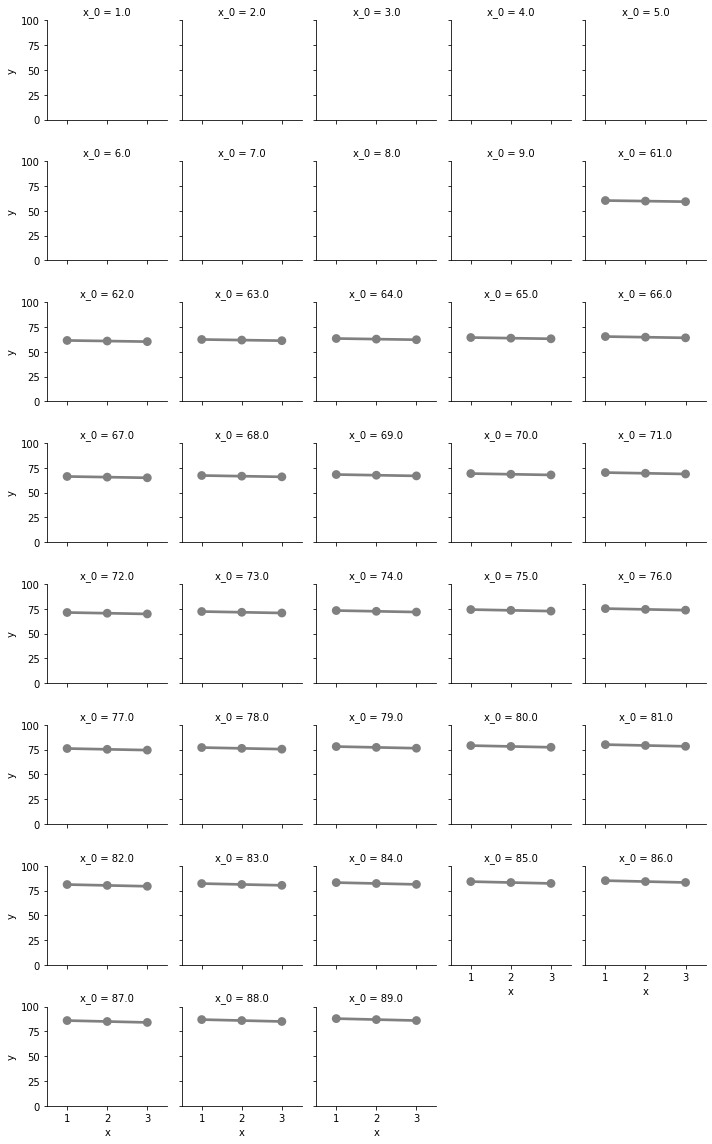

In [9]:
g = sns.FacetGrid(newtons_law_df, col="x_0",col_wrap=5, height=2, ylim=(0, 100))
g.map(sns.pointplot, "x", "y", order=[1, 2, 3], color=".5", ci=None)

This is newtons graphs for the predictions made by the neural network

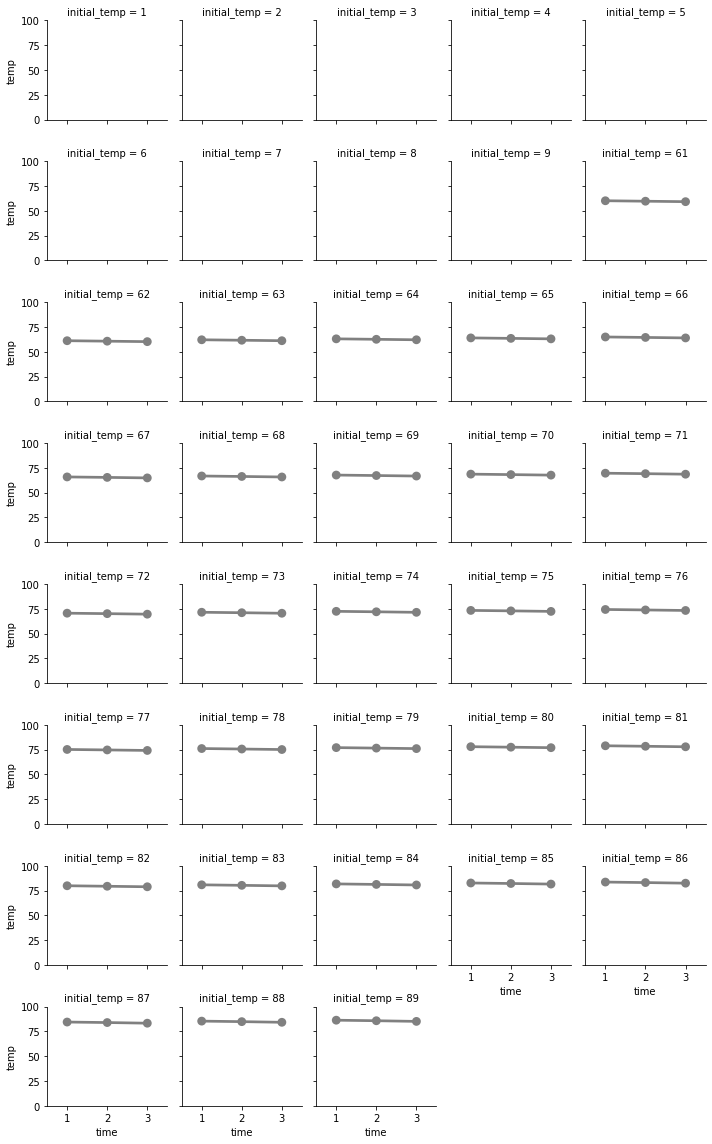

In [10]:
g = sns.FacetGrid(newtons_law_df_preds, col="initial_temp",col_wrap=5, height=2, ylim=(0, 100))
g.map(sns.pointplot, "time", "temp", order=[1, 2, 3], color=".5", ci=None)

Below would show a categorical graph defined by initial temp as a category and the temperature on the y axises.

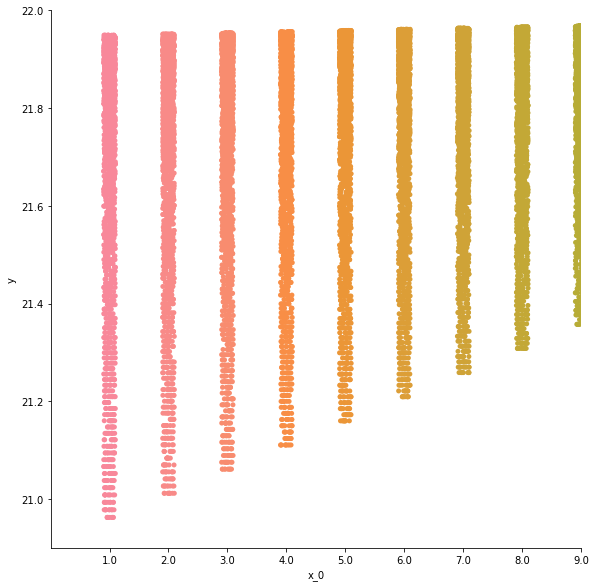

In [11]:
sns.catplot(height=8, data=newtons_law_df, x="x_0", y="y").set(xlim=(-1,8), ylim=(20.9,22))

This below show the predictions from the neural network

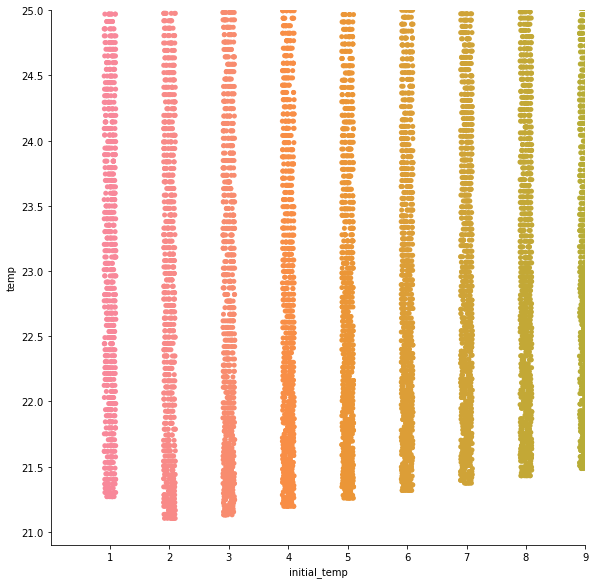

In [12]:
sns.catplot(height=8, data=newtons_law_df_preds, x="initial_temp", y="temp").set(xlim=(-1,8), ylim=(20.9,25))

## Combining both

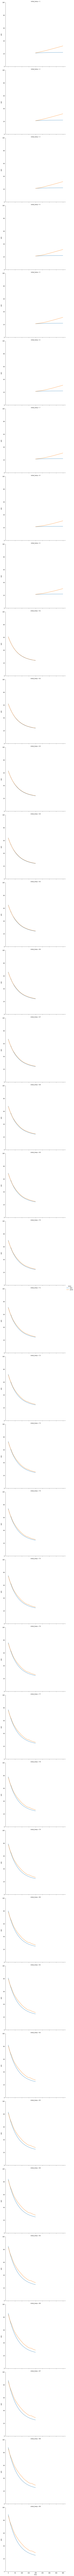

In [13]:
g = sns.FacetGrid(newtons_law_df_compare, hue="temp", col="initial_temp",col_wrap=1, height=8, ylim=(0, 100))
g.map(sns.lineplot, "time", "vals", ci=None)
g.add_legend()

From the graph it appears like the neural network is not good at predicting feature time series at when t>199. The neural network works better at predicting neural networks within the time series (0<=t<200), as it carries on with the trend.

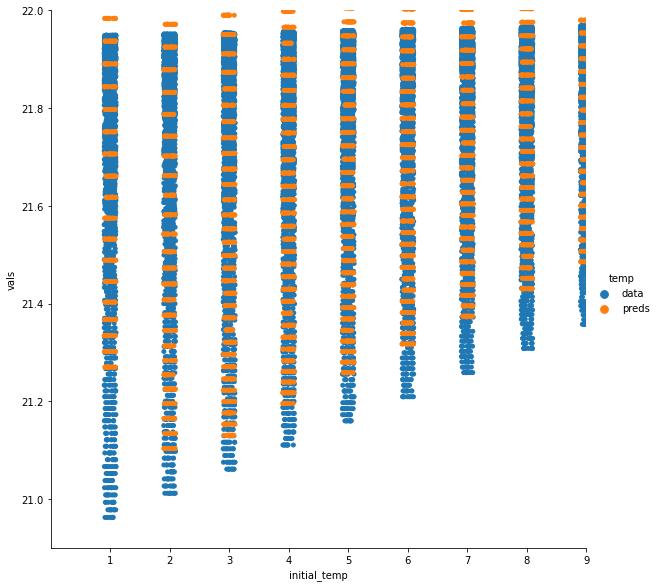

In [14]:
sns.catplot(height=8, data=newtons_law_df_compare, x="initial_temp", y="vals", hue="temp").set(xlim=(-1,8), ylim=(20.9,22))